# CNN
Description: This is a multi-label classification problem based on business themes classification according their company regulations

Motivation: With this project we can assembly knowledge we learned through this semester includeing data preprocessing, words representation and several Deep Learning models.
Research questions: How many filter and how big size is better for CNN?

Challenges: we 're keeping trying to use CNN text classification but it really depends the learning rates at first, it's hard to decide a good starting point.
Recently result: The multi-label classification has beeb applied on diseases diagnose very often, and many are based on supervised model like C4.5 and SVM.


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 30.2 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from keras.utils import pad_sequences
from torchmetrics.classification import MultilabelF1Score
from matplotlib import pyplot as plt
import torch.nn as nn
from gensim.models import word2vec
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/DataSolveUS_BIA667_Project/

Mounted at /content/drive
/content/drive/My Drive/DataSolveUS_BIA667_Project


In [ ]:
metric = MultilabelF1Score(num_labels=50)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = pd.read_csv("train_data_clean.csv", parse_dates=[0])
features = ["name","document_text","cat_id_all"]
x_data = data["name"]+data["document_text"]
# create frequency dictionary
word_dict = Counter([word for sentence in x_data for word in sentence.split(' ')])
low_frequency_words = [k for (k,v) in  word_dict.items() if v <5]
high_frequency_words = [k for (k,v) in  word_dict.most_common(6)]
short_words = [k for (k,v) in  word_dict.items() if len(k)<2]
short_words.append('\'s')
to_remove = set(low_frequency_words + high_frequency_words + short_words)
cleaned_data = [' '.join([word for word in sentence.split(' ') if not word in to_remove]) for sentence in x_data]
tokenizer = Tokenizer(oov_token='<UNK>')
#Spliting dataset into train and test sets
y_data = data["cat_id_all"]
train_test_cut_off = int(len(cleaned_data)*0.8)

x_train_data = cleaned_data[:train_test_cut_off]
y_train_data = y_data.iloc[:train_test_cut_off].values
train_data_id = data["id"].iloc[:train_test_cut_off].values
#tokenalize:
tokenizer.fit_on_texts(x_train_data)
training_seq = tokenizer.texts_to_sequences(x_train_data)

x_test_data = cleaned_data[train_test_cut_off:]
y_test_data = y_data.iloc[train_test_cut_off:].values
test_data_id = data["id"].iloc[train_test_cut_off:].values

testing_seq = tokenizer.texts_to_sequences(x_test_data)
#process target category to numerical list
for i in range(len(y_test_data)):
    y_test_data[i] = y_test_data[i].split(',')


for i in range(len(y_test_data)):
    for j in range(len(y_test_data[i])):
        y_test_data[i][j] = int(y_test_data[i][j])
# for i in range(len(y_test_data)):
#     y_test_data[i] = np.array(y_test_data[i])

for i in range(len(y_train_data)):
    y_train_data[i] = y_train_data[i].split(',')

for i in range(len(y_train_data)):
    for j in range(len(y_train_data[i])):
        y_train_data[i][j] = int(y_train_data[i][j])

y_train_data = y_train_data.tolist()
y_test_data = y_test_data.tolist()
# convert y to 50 length vector
for i in range(len(y_train_data)):
    y_train_data[i] = torch.nn.functional.one_hot(torch.tensor(y_train_data[i]),50).sum(axis=0).tolist()
for i in range(len(y_test_data)):
    y_test_data[i] = torch.nn.functional.one_hot(torch.tensor(y_test_data[i]),50).sum(axis=0).tolist()




In [ ]:
DOC_LEN = 600
train_x = pad_sequences(training_seq,value=0,padding='post',maxlen=DOC_LEN)
test_x = pad_sequences(testing_seq,value=0,padding='post',maxlen=DOC_LEN)

Baseline model
SVM

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier

# Create the SVM
svm = LinearSVC(random_state=50)

# Make it an Multilabel classifier
multilabel_classifier = MultiOutputClassifier(svm, n_jobs=-1)

# Fit the data to the Multilabel classifier
multilabel_classifier = multilabel_classifier.fit(train_x, y_train_data)

# Get predictions for test data
y_test_pred = multilabel_classifier.predict(test_x)
y_test_data_svm = np.array(y_test_data)
cur_train_acc = metric(torch.tensor(y_test_pred), torch.tensor(y_test_data_svm))


In [ ]:
print("BaseLine Accuracy: ", cur_train_acc)

BaseLine Accuracy:  tensor(0.1065)


In [ ]:
class US_dataset(Dataset):
    def __init__(self, featuers, labels):
        self.length = len(labels)
        self.features = torch.IntTensor(featuers)
        self.labels = torch.Tensor(labels)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

    def __len__(self):
        return self.length

# datasets
train_dataset = US_dataset(train_x, y_train_data)
test_dataset = US_dataset(test_x, y_test_data)


Algorithm and model

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, num_words_in_dict, embedding_dim, dropout_ratio):
        super(TextCNN, self).__init__()
        self.num_words_in_dict = num_words_in_dict
        self.embedding_dim = embedding_dim
        self.dropout_ratio = dropout_ratio

        # embedding
        self.embedding = nn.Embedding(num_embeddings=num_words_in_dict,
                                      embedding_dim=embedding_dim)  # (-1, DOC_LEN, embedding_dim), num_embedding: embedding dict size, embedding_dim: length of embedding vector

        # 1D CNN
        # unigram
        self.unigram = nn.Sequential(  # input (-1, embedding_dim, DOC_LEN)
            nn.Conv1d(in_channels=embedding_dim, out_channels=64, kernel_size=1),  # (-1, 64, DOC_LEN)
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=DOC_LEN),  # (-1, 64, 1)
            nn.Flatten()  # (-1, 64 * 1)
        )
        # bigram
        self.bigram = nn.Sequential(  # input (-1, embedding_dim, DOC_LEN)
            nn.Conv1d(in_channels=embedding_dim, out_channels=64, kernel_size=2),
            # (-1, 64, DOC_LEN-2+1) ??? why DOC_LEN - 2 + 1
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=DOC_LEN - 2 + 1),  # (-1, 64, 1)
            nn.Flatten()  # (-1, 64 * 1)
        )
        # trigram
        self.trigram = nn.Sequential(  # input (-1, embedding_dim, DOC_LEN)
            nn.Conv1d(in_channels=embedding_dim, out_channels=64, kernel_size=3),  # (-1, 64, DOC_LEN-3+1)
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=DOC_LEN - 3 + 1),  # (-1, 16, 7)
            nn.Flatten()  # (-1, 64 * 1)
        )
        #4th
        self.fourgram = nn.Sequential(  # input (-1, embedding_dim, DOC_LEN)
            nn.Conv1d(in_channels=embedding_dim, out_channels=64, kernel_size=4),  # (-1, 64, DOC_LEN-3+1)
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=DOC_LEN - 4 + 1),  # (-1, 16, 7)
            nn.Flatten()  # (-1, 64 * 1)
        )
        #5th
        self.fifgram = nn.Sequential(  # input (-1, embedding_dim, DOC_LEN)
            nn.Conv1d(in_channels=embedding_dim, out_channels=64, kernel_size=5),  # (-1, 64, DOC_LEN-3+1)
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=DOC_LEN - 5 + 1),  # (-1, 16, 7)
            nn.Flatten()  # (-1, 64 * 1)
        )
        #6th
        self.sixgram = nn.Sequential(  # input (-1, embedding_dim, DOC_LEN)
            nn.Conv1d(in_channels=embedding_dim, out_channels=64, kernel_size=6),  # (-1, 64, DOC_LEN-3+1)
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=DOC_LEN - 6 + 1),  # (-1, 16, 7)
            nn.Flatten()  # (-1, 64 * 1)
        )
        # simple classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_ratio),
            nn.Linear(in_features=64 * 6, out_features=50)
        )

    def forward(self, x):
        # get embedding
        x = self.embedding(x)
        # make sure we are convolving on each word
        x = torch.transpose(x, dim0=1,
                            dim1=2)  # (-1, DOC_LEN, embedding_dim): embedding on 1(DOC_LEN) & 2(embedding_dim) dims
        # 1d cnn output
        uni_gram_output = self.unigram(x)
        bi_gram_output = self.bigram(x)
        tri_gram_output = self.trigram(x)
        four_gram_output = self.fourgram(x)
        fif_gram_output = self.fifgram(x)
        six_gram_output = self.sixgram(x)
        # concatenate
        x = torch.cat((uni_gram_output, bi_gram_output, tri_gram_output,four_gram_output,fif_gram_output,six_gram_output), dim=1)
        # classifier
        x = self.classifier(x)

        return x

In [ ]:
model=TextCNN(12150,150,0.2)

In [ ]:
def train_model(model, train_dataset, test_dataset, device, lr=0.0001, epochs=20, batch_size=32):
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': [],
               'prediction':[]}

    # setup loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        prediction =[]
        for x, y in train_loader:
            # move data to device
            x = x.to(device)
            y = y.to(device)
            # forward
            # outputs = model(x).view(-1)
            outputs = model(x)
            pred = torch.round(torch.sigmoid(outputs))
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = metric(pred,y)
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                # outputs = model(x).view(-1)
                outputs = model(x)
                pred = torch.round(torch.sigmoid(outputs))
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = metric(pred,y)
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc
                #add prediction to history
                prediction.append(pred)
                if epoch==1000:
                    print("epoch reached")
        history['prediction'].append(prediction)
        # epoch output
        train_loss = (train_loss / len(train_loader)).item()
        train_acc = (train_acc / len(train_loader)).item()
        val_loss = (test_loss / len(test_loader)).item()
        val_acc = (test_acc / len(test_loader))
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc)
        print(
            f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.4f} train_acc:{train_acc:.4f}, valid loss:{val_loss:.4f} valid acc:{val_acc:.5f}")

    return history

In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=test_dataset,
                      device=device,
                      lr=0.0002,
                      epochs=50,
                      batch_size=128)
prediction = pd.DataFrame({"prediction":history['prediction'],"train_loss":history['train_loss'],"test_loss":history['test_loss'],"train_acc":history['train_acc'],"test_acc":history['test_acc']})
prediction.to_csv("results.csv")

Training Start
Epoch:1 / 50, train loss:0.3961 train_acc:0.0216, valid loss:0.2758 valid acc:0.00000
Epoch:2 / 50, train loss:0.3139 train_acc:0.0037, valid loss:0.2690 valid acc:0.00067
Epoch:3 / 50, train loss:0.2999 train_acc:0.0157, valid loss:0.2577 valid acc:0.00853
Epoch:4 / 50, train loss:0.2853 train_acc:0.0548, valid loss:0.2480 valid acc:0.04618
Epoch:5 / 50, train loss:0.2701 train_acc:0.1137, valid loss:0.2379 valid acc:0.09345
Epoch:6 / 50, train loss:0.2570 train_acc:0.1785, valid loss:0.2265 valid acc:0.15158
Epoch:7 / 50, train loss:0.2439 train_acc:0.2399, valid loss:0.2161 valid acc:0.19282
Epoch:8 / 50, train loss:0.2322 train_acc:0.2933, valid loss:0.2094 valid acc:0.23189
Epoch:9 / 50, train loss:0.2222 train_acc:0.3355, valid loss:0.2004 valid acc:0.25435
Epoch:10 / 50, train loss:0.2136 train_acc:0.3689, valid loss:0.1947 valid acc:0.28221
Epoch:11 / 50, train loss:0.2062 train_acc:0.4014, valid loss:0.1892 valid acc:0.32054
Epoch:12 / 50, train loss:0.1994 trai

[]

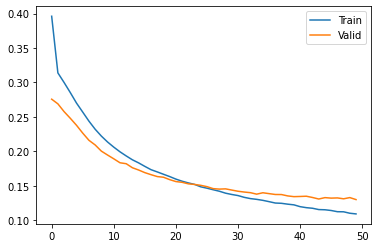

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(0, 50), history['train_loss'], label='Train')
plt.plot(range(0, 50), history['test_loss'], label='Valid')
plt.legend()
plt.plot()

[]

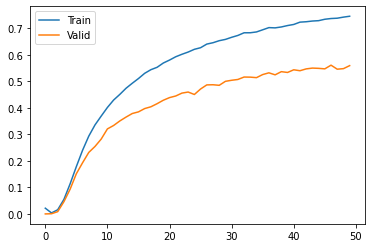

In [ ]:
plt.plot(range(0, 50), history['train_acc'], label='Train')
plt.plot(range(0, 50), history['test_acc'], label='Valid')
plt.legend()
plt.plot()

Future work: We want to try more convolution kernal and strides. We also need to experiment different optimizer to determine the better combination.